# Example of Conditional GAN network on the cifar10 dataset
<img src="https://i.ytimg.com/vi/71Wg3GQGyx0/maxresdefault.jpg" alt="Conditional GAN Architecture" />

Imports

In [1]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Concatenate, Embedding
from keras.models import Sequential, Model
try:
    from keras.optimizers.legacy import Adam
except ImportError:
    from keras.optimizers import Adam
from keras.utils import plot_model, set_random_seed
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

Load dataset and define some inputs

In [2]:
(i1, l1), (i2, l2) = cifar10.load_data() # load dataset
images = np.concatenate((i1, i2)) # combine training and testing images so we have more data
labels = np.concatenate((l1, l2)) # combine training and testing labels so we have more data
img_shape = images.shape[1:] # image shape with single channel (28x28x1)
noise_length = 128 # length of the latent vector (noise vector)
n_classes = 10 # number of classes in the mnist dataset
optimizer = Adam(0.0002, 0.5) # defining the optimizer
set_random_seed(1000) # Sets all random seeds (Python, NumPy, and backend framework, e.g. TF).

The generator network: Given input of noise (latent) vector, the Generator produces an image.

In [3]:
def build_generator():
    label_input_raw = Input(shape=(1,), dtype='int32')
    label_input = Embedding(n_classes, 50)(label_input_raw)
    label_input = Flatten()(label_input)
    label_input = Dense(8*8*2)(label_input)
    label_input = Reshape((8, 8, 2))(label_input)
    
    noise_input_raw = Input(shape=(noise_length,))
    noise_input = Dense(30*8*8)(noise_input_raw)
    noise_input = LeakyReLU(alpha=0.2)(noise_input)
    noise_input = Reshape((8, 8, 30))(noise_input)
    
    merge_input = Concatenate()([noise_input, label_input])
    
    out = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge_input)
    out = LeakyReLU(alpha=0.2)(out)
    out = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(out)
    out = LeakyReLU(alpha=0.2)(out)
    out = Conv2D(32, (8,8), padding='same')(out)
    out = LeakyReLU(alpha=0.2)(out)
    out = Conv2D(3, (2,2), activation='tanh', padding='same')(out)
    return Model([noise_input_raw, label_input_raw], out, name="Generator_Network")

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
generator.summary(expand_nested=True)
plot_model(generator, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)
try:
    generator.load_weights('cgan_cifar10_generator_weights.h5')
except FileNotFoundError:
    pass

Model: "Generator_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1920)         247680      ['input_2[0][0]']                
                                                                                  

The discriminator network: Given an input image, the Discriminator outputs the likelihood of the image being real.

Model: "Discriminator_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_4[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 1, 1024)      52224       ['embedding_1[0][0]']            
                                                                                                  
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                              

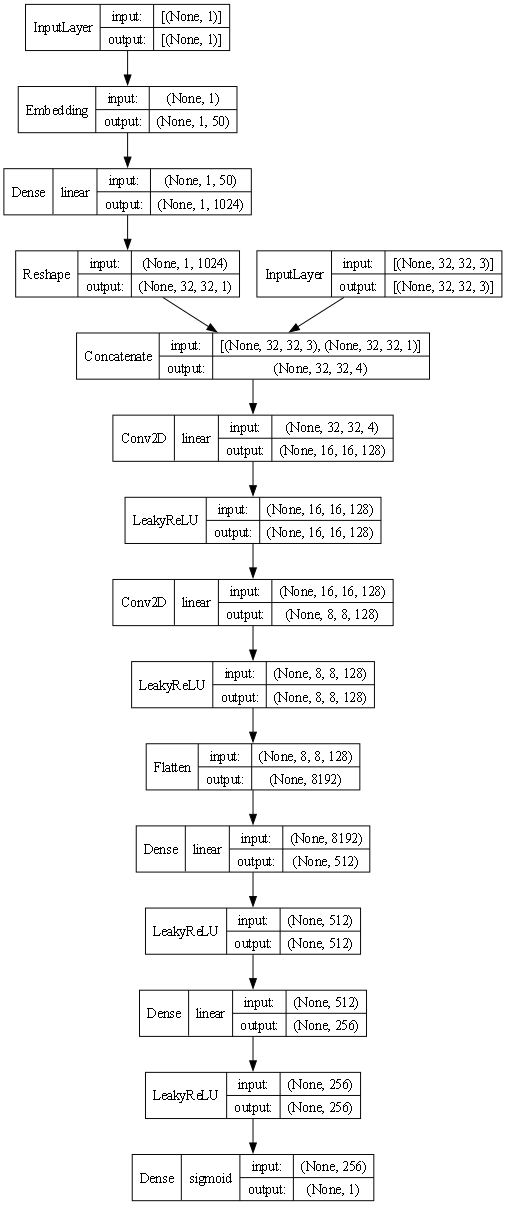

In [4]:
def build_discriminator():
    img_input = Input(shape=img_shape)
    
    label_input_raw = Input(shape=(1,), dtype='int32')
    label_input = Embedding(n_classes, 50)(label_input_raw)
    label_input = Dense(img_shape[0]*img_shape[1])(label_input)
    label_input = Reshape((img_shape[0],img_shape[1], 1))(label_input)
    
    merge_input = Concatenate()([img_input, label_input])
    
    out = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge_input)
    out = LeakyReLU(alpha=0.2)(out)
    out = Conv2D(128, (3,3), strides=(2,2), padding='same')(out)
    out = LeakyReLU(alpha=0.2)(out)
    out = Flatten()(out)
    out = Dense(512)(out)
    out = LeakyReLU(alpha=0.2)(out)
    out = Dense(256)(out)
    out = LeakyReLU(alpha=0.2)(out)
    out = Dense(1, activation='sigmoid')(out)
    return Model([img_input, label_input_raw], out, name="Discriminator_Network")

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator.summary(expand_nested=True)
plot_model(discriminator, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)

-------------------------------------------------------------------
The ultimate goal here is for the Generator to fool the Discriminator.  
The combined model  (stacked generator and discriminator) takes
noise as input => generates images => determines validity

Model: "CGAN_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 Generator_Network (Functional)  (None, 32, 32, 3)   845207      ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)         [(None, 1)]          0           []                     

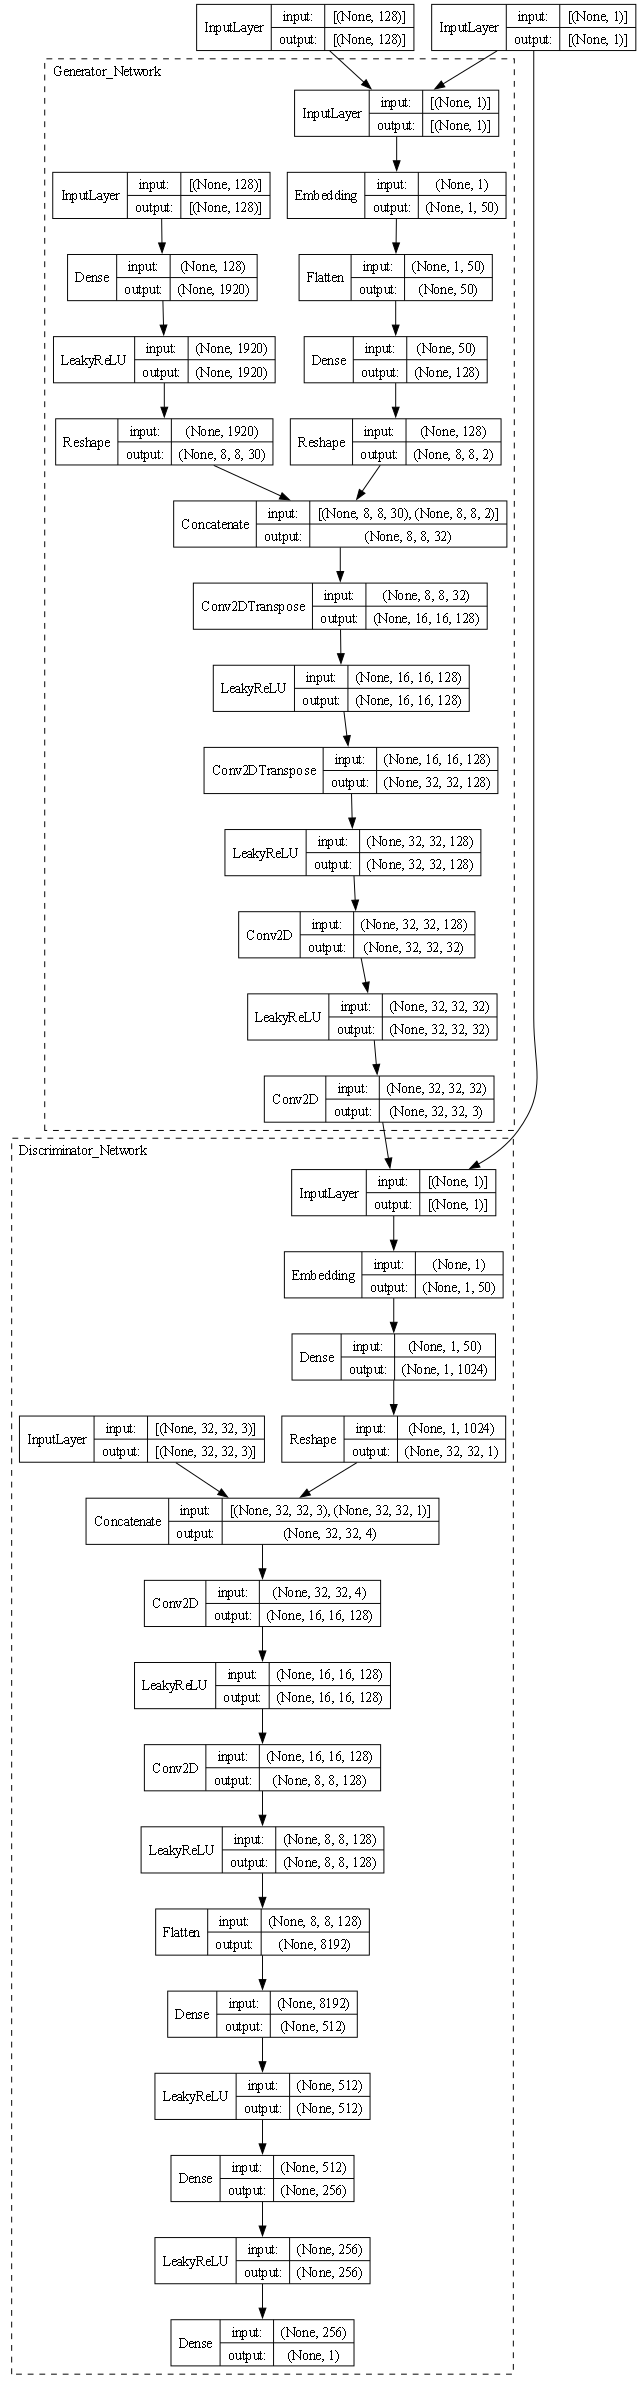

In [5]:
def build_cgan():
    noise_input = Input(shape=(noise_length,))
    label_input_raw = Input(shape=(1,), dtype='int32')
    img = generator([noise_input, label_input_raw])

    # While generator training we do not want discriminator weights to be trained.
    discriminator.trainable = False

    valid = discriminator([img, label_input_raw])  #Validity check on the generated image

    return Model([noise_input, label_input_raw], valid, name="CGAN_Network")

cgan = build_cgan()
cgan.compile(loss='binary_crossentropy', optimizer=optimizer)
cgan.summary(expand_nested=True)
plot_model(cgan, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)

In order to train the GAN network we have to let the generator and the discriminator to compete with each other.

In [ ]:
def train(epochs, batch_size=128, plot_interval=50):
    # Convert to float and Rescale -1 to 1
    X_train = (images.astype(np.float32) - 127.5) / 127.5

    # Add channels dimension.
    if X_train.ndim<4:
        X_train = np.expand_dims(X_train, axis=3)

    # We then loop through a number of epochs to train our Discriminator by first selecting
    # a random batch of images from our true dataset, generating a set of images from our
    # Generator, feeding both set of images into our Discriminator, and finally setting the
    # loss parameters for both the real and fake images, as well as the combined loss.

    for epoch in tqdm(range(epochs)):
        if epoch % plot_interval == 0:
            generator.save_weights('cgan_cifar10_generator_weights.h5')
            plot_imgs(epoch)
        # for i in range(len(X_train) // batch_size):
        # Train Discriminator
        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        # idx = range(i * batch_size, (i + 1) * batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, noise_length))
        lb = np.random.randint(0, n_classes, batch_size).reshape(-1, 1)

        # Generate a half batch of fake images
        gen_imgs = generator.predict([noise, lb], verbose=0)

        # Train the discriminator on real and fake images, separately
        # Research showed that separate training is more effective.
        d_loss_real = discriminator.train_on_batch([imgs, labels[idx].reshape(-1, 1)], np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch([gen_imgs, lb], np.zeros((batch_size, 1)))

        # take average loss from real and fake images.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # And within the same loop we train our Generator, by setting the input noise and
        # ultimately training the Generator to have the Discriminator label its samples as valid
        # by specifying the gradient loss.

        # Train Generator
        # Create noise vectors as input for generator.
        # Create as many noise vectors as defined by the batch size.
        # Based on normal distribution. Output will be of size (batch size, noise_length)
        noise = np.random.normal(0, 1, (batch_size, noise_length))
        lb = np.random.randint(0, n_classes, batch_size).reshape(-1, 1)


        # The generator wants the discriminator to label the generated samples as valid (ones)
        # This is where the genrator is trying to trick discriminator into believing
        # the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) # Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        # job of folling the discriminator then the output would be 1 (true)
        g_loss = cgan.train_on_batch([noise, lb], valid_y)


def plot_imgs(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, noise_length))
    lb = np.arange(10).reshape(-1, 1)
    gen_imgs = generator.predict([noise, lb], verbose=0)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, :])
            axs[i,j].axis('off')
            cnt += 1
    fig.suptitle('Output of the generator network at epoch %d ' % epoch, fontsize=10)
    # fig.savefig("images/mnist_%d.png" % epoch)
    plt.show()


train(epochs=10000, batch_size=256, plot_interval=100)